In [1]:
%matplotlib inline

# Módulo 4 - Aula 2: SVM Linear + RBF

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/456](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Instituto de Computação - Unicamp 2021

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

# Datasets

Nesta atividade, iremos utilizar 3 datasets binários sintéticos com exemplos com duas features:
- **Moon**: cada classe possúi o formato de uma lua;
- **Circle**: classes estão distribuídas em círculos concêntricos;
- **Linearly Separable**: as classes são linearmente separáveis;

In [3]:
h = .02  # step size

# Dataset Linearmente Separável
# sklearn.datasets.make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# Lista com os datasets
# sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)
datasets = [linearly_separable, 
            make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1)]

Iremos dividir cada dataset em treino e teste e vamos visualizar nossos dados. Os exemplos transparentes (com `alpha` reduzido são referentes às amostras de teste). 

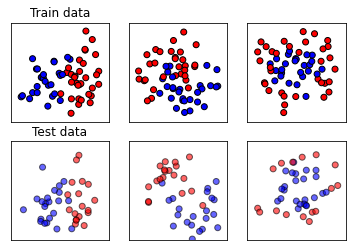

In [4]:
trainTestData = []
for ds_cnt, ds in enumerate(datasets):
    # pre-processamento, split em treino e teste
    X, y = ds
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    # remove a média e escala para variância 1
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Vamos salvar os splits de treino/teste para utilizá-los depois
    trainTestData.append((X_train, X_test, y_train, y_test))
    
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))  
    
    # mostra o dataset com um colormap
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(2, len(datasets), ds_cnt+1)
    if ds_cnt == 0:
        ax.set_title("Train data")

    # mostra os dados de treinamento
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    
    # mostra os dados de teste
    ax = plt.subplot(2, len(datasets), ds_cnt + 1 + len(datasets))
    if ds_cnt == 0:
        ax.set_title("Test data")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
plt.show()

__________
## SVM com kernel linear

Para cada dataset, iremos treinar um SVM com kernel linear, variando o parâmetro `C`.

O parâmetro ``C`` busca um balanço entre classificação correta no treinamento e maximização da margem de separação das classes. Valores baixos visam maximizar a margem, criando funções de separação mais simples (se muito simples --> underfitting). Valors altos penalizam mais erros no treino, criando funções de separação mais complicadas (se muito complexa --> overfitting).

In [5]:
def train_test_plot(data, penaltyArray = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]):
    X_train, X_test, y_train, y_test = data
    fignum = 1
    
    for penalty in penaltyArray:
        #treinamos o SVM 
        clf = svm.SVC(kernel='linear', C=penalty)
        clf.fit(X_train, y_train)

        # obtendo o hiperplano
        w = clf.coef_[0]
        #print (w)
        a = -w[0] / w[1]
        #print (a)
        xx = np.linspace(-5, 5)
        yy = a * xx - (clf.intercept_[0]) / w[1]
        #print (yy)
        
        # mostra as paralelas ao hiperplano que passam pelos suppoort vectors
        margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
        yy_down = yy - np.sqrt(1 + a ** 2) * margin
        yy_up = yy + np.sqrt(1 + a ** 2) * margin

        # mostra a linha, pontos e vizinhos ao plano
        plt.figure(fignum, figsize=(5, 4))
        plt.clf()
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        # plotamos os dados de treino, teste e os vetores de suporte
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='none', zorder=10, edgecolors='k')
        plt.scatter(X_train[:,0], X_train[:,1], c=y_train, zorder=10, cmap=cm_bright,
                    edgecolors='k')
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, zorder=10, cmap=cm_bright, alpha = 0.5,
                    edgecolors='k')

        plt.axis('tight')
        x_min = -4.8
        x_max = 4.2
        y_min = -6
        y_max = 6

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # coloca os resultados no gráfico
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 4))
        plt.pcolormesh(XX, YY, Z, cmap=cm_bright, alpha=0.05)

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        
        # calculamos a acurácia de treino e teste para compararmos
        trainAcc = accuracy_score(y_train, clf.predict(X_train))
        testAcc = accuracy_score(y_test, clf.predict(X_test))
        
        
        plt.title("C = {} trainAcc = {:.2f} testAcc = {:.2f}".format(penalty, trainAcc, testAcc))
        fignum = fignum + 1


Rodando no dataset **Linearly Separable**:

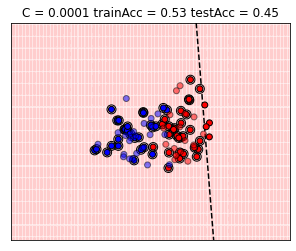

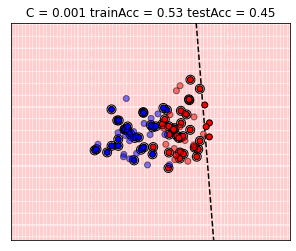

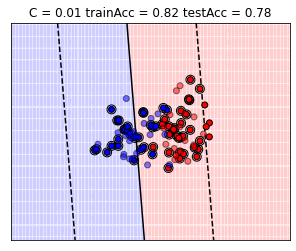

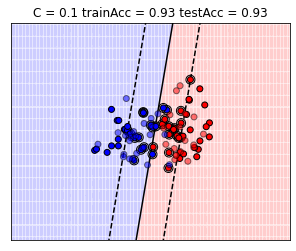

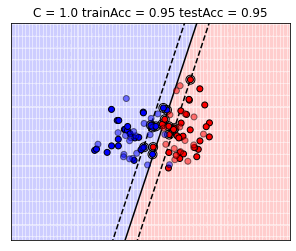

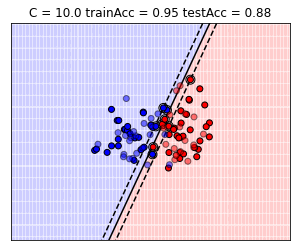

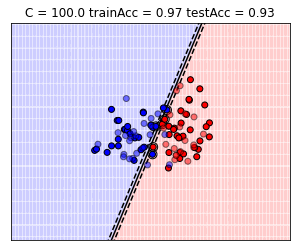

In [5]:
train_test_plot(trainTestData[0])

Rodando no dataset **Moon**:

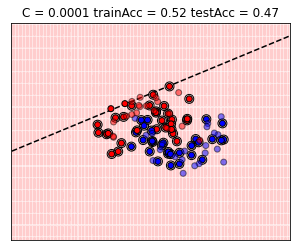

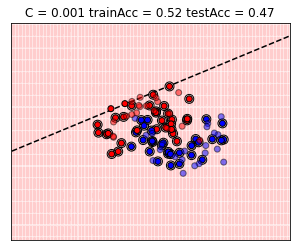

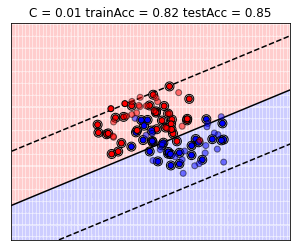

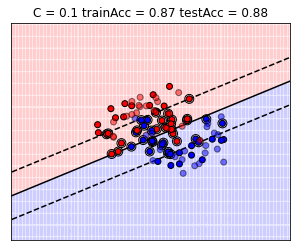

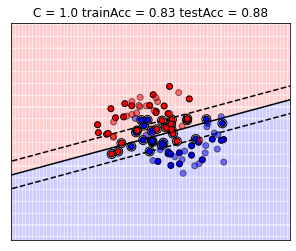

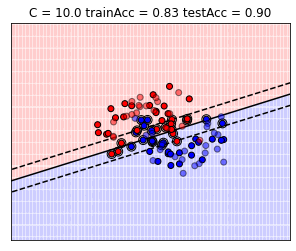

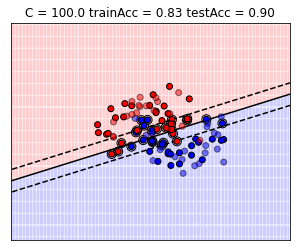

In [6]:
train_test_plot(trainTestData[1])

Rodando no dataset **Circle**:

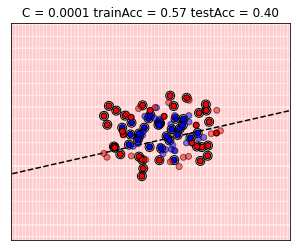

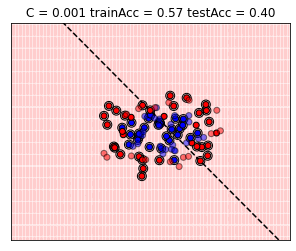

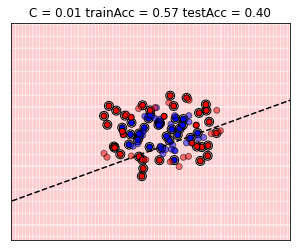

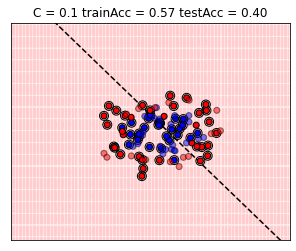

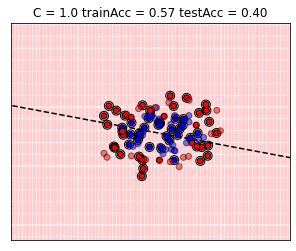

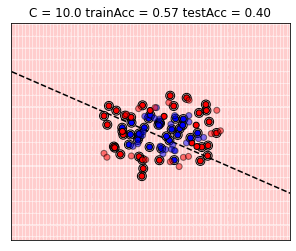

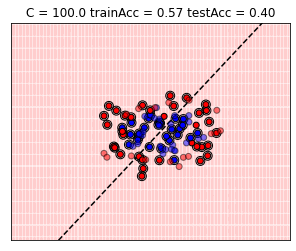

In [7]:
train_test_plot(trainTestData[2])

-----------------
-----------------

## SVM com kernel RBF

Dessa vez, iremos treinar um SVM com kernel RBF, variando tanto o parâmetro `C`, como `gamma`.

O parâmetro ``gamma`` define quão longe a influência de um único exemplo de treinamento pode alcançar. Valores baixos significam 'longe' e valores altos 'perto'. Pode ser visto como o inverso do raio de influência de amostras selecionadas como vetores de suporte.

No exemplo, quando ``gamma`` é muito pequeno o modelo não captura forma de sepração dos dados e comporta-se como um modelo linear.  Por outro lado, se o ``gamma`` é muito grande, o raio de influência dos vetores de suporte inclui apenas o próprio vetor de suporte e o ``C`` não consegue evitar o overfitting.

In [6]:
from itertools import product
def train_test_plot_RBF(data, penaltyArray=[1e-1, 1.0, 10.0], gammaArray= [1e-1, 1.0, 10.0], kernel='rbf'):
    X_train, X_test, y_train, y_test = data
    plt.figure(figsize=(24, 18))
    
    for (k, (penalty, gamma)) in enumerate(product(penaltyArray, gammaArray)):
        clf = svm.SVC(kernel=kernel, C=penalty, gamma=gamma)
        clf.fit(X_train, y_train)

        # calculamos a acc de treino e teste
        trainAcc = accuracy_score(y_train, clf.predict(X_train))
        testAcc = accuracy_score(y_test, clf.predict(X_test))
        
        xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
        
        # avalia a função de decisão no grid
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # visualiza a função de decisão com os parametros
        plt.subplot(len(penaltyArray), len(gammaArray), k + 1)
        plt.title("gamma=%.2f, C=%.2f, trainAcc=%.2f, testAcc=%.2f" % (gamma, penalty, trainAcc, testAcc), 
                  size='medium')

        # visualize parameter's effect on decision function
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                    edgecolors='k')
        plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=cm_bright, alpha = 0.5,
                    edgecolors='k')
        
        
        plt.xticks(())
        plt.yticks(())
        plt.axis('tight')



Rodando no dataset **Linearly Separable**:

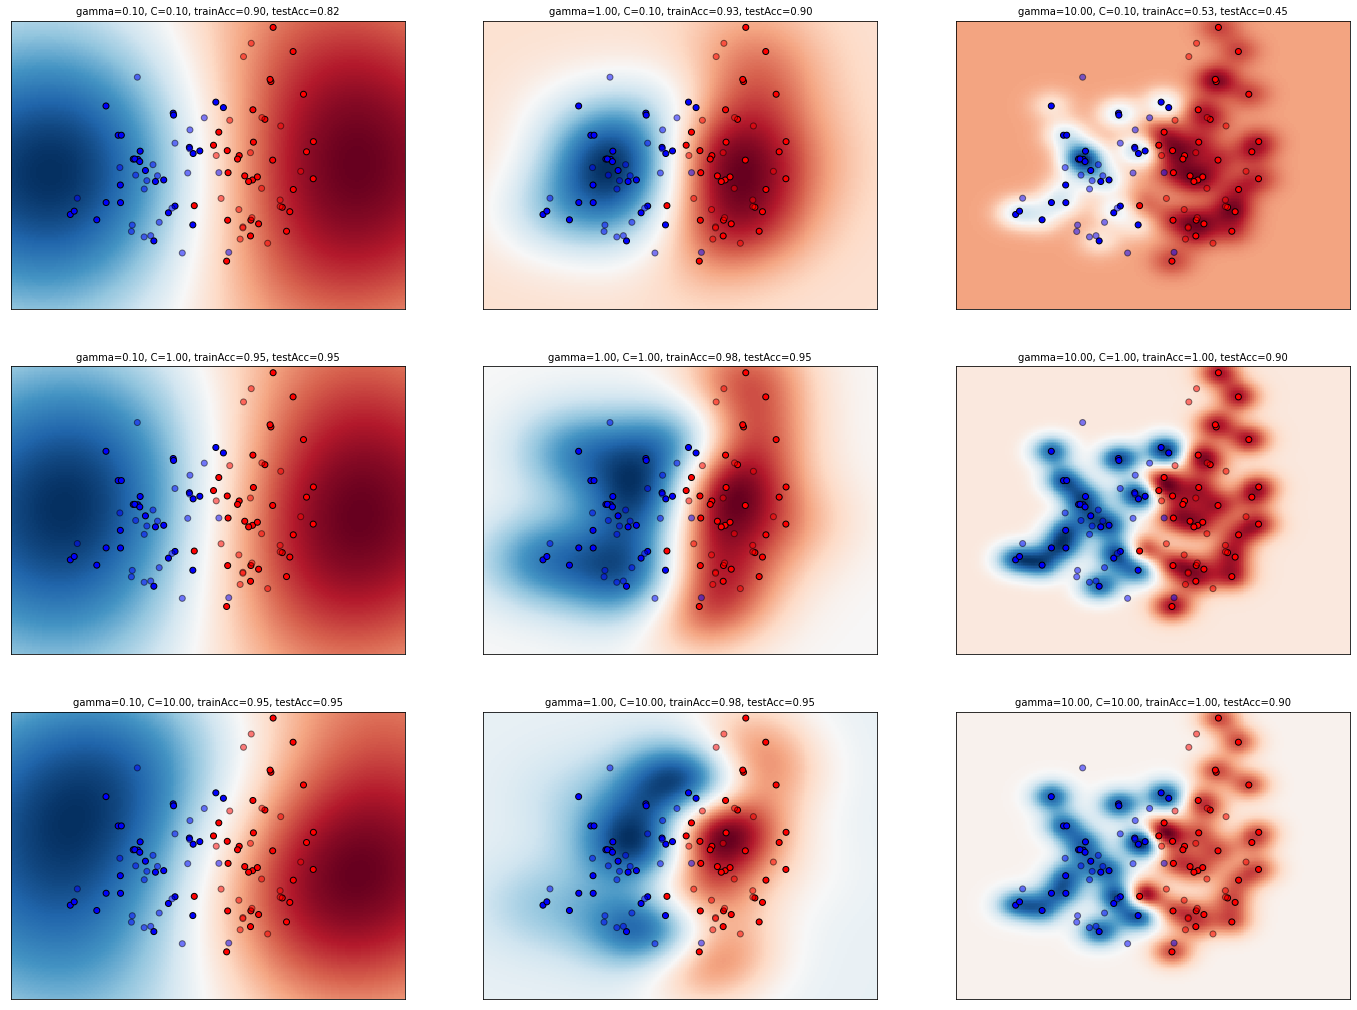

In [9]:
train_test_plot_RBF(trainTestData[0])

Rodando no dataset **Moon**:

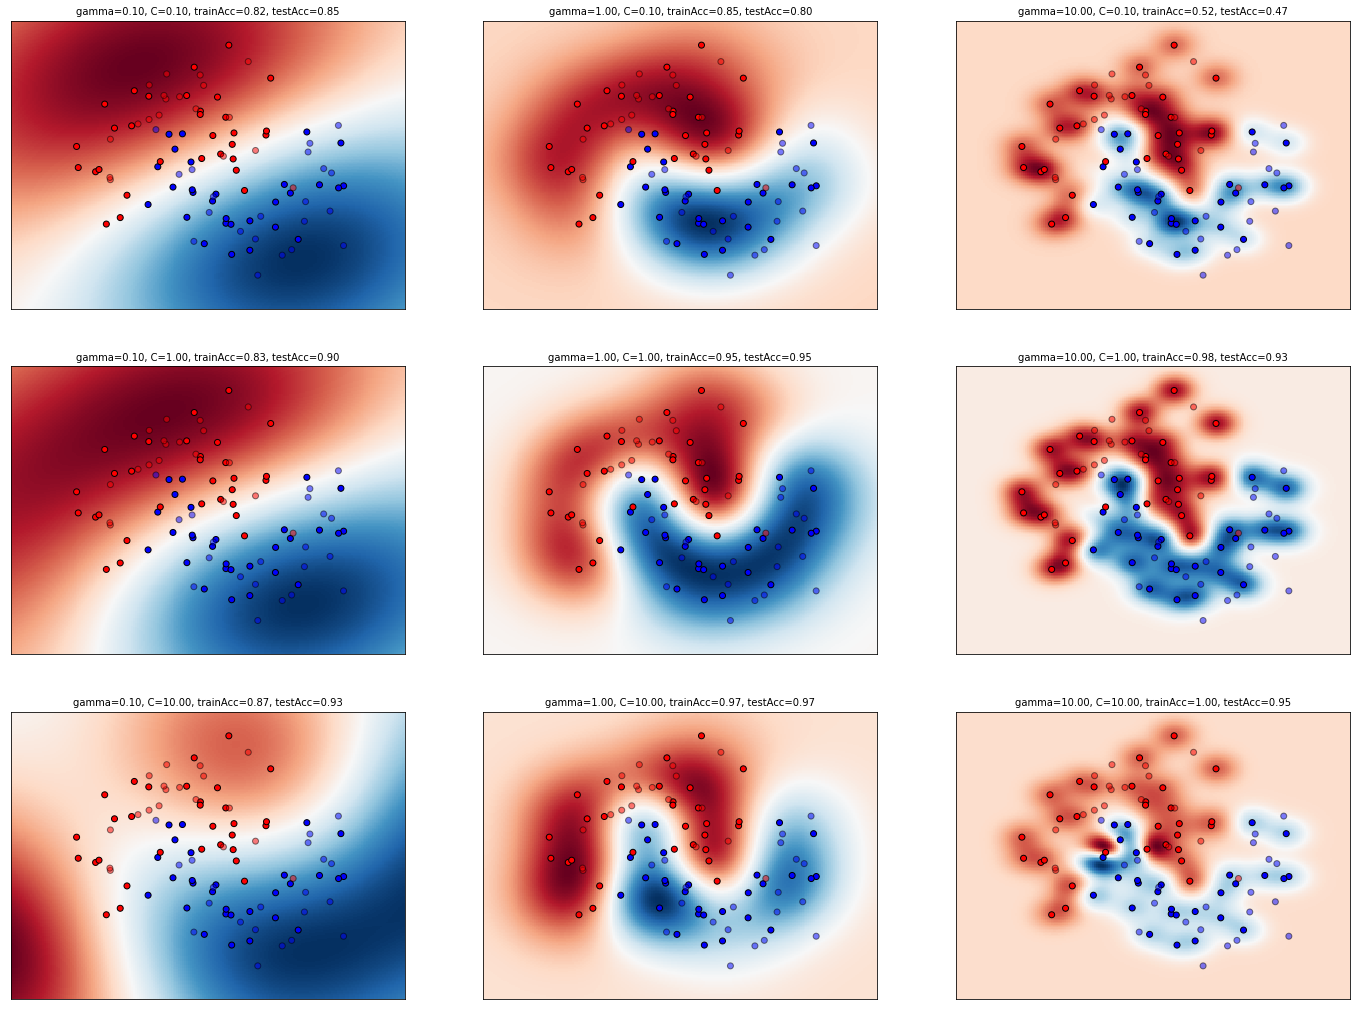

In [10]:
train_test_plot_RBF(trainTestData[1])

Rodando no dataset **Circle**:

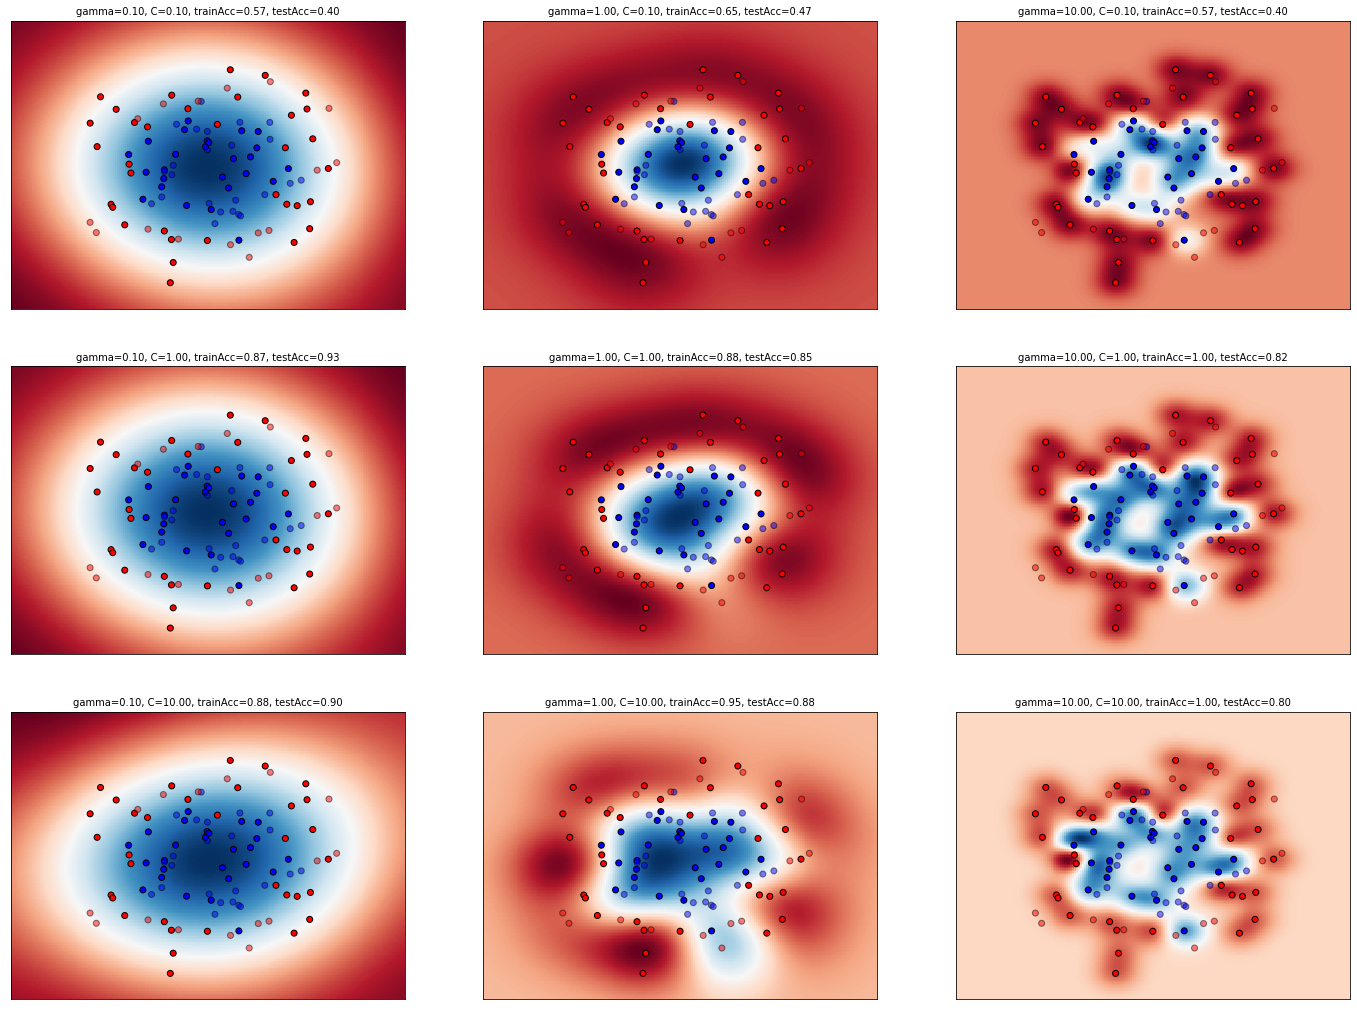

In [11]:
train_test_plot_RBF(trainTestData[2])